In [1]:
# В данно примере будем делать сеть которая будет предсказывать кто на фото - кошка или собака. 
# Сеть буду обучать на ч/б фотографиях (берем 1ин цветовой канал из 3ех) ибо мое железо не тянет цветовые фотографии
# Данная сеть имеет точность 75 - 80 % за 10 эпох (возможно и больше в связи с малым кол-вом эпох), но 
# можно увеличить кол-во эпох обучения ибо с каждой эпохой точность росла + добавить слой Dense с переборкой кол-ва нейронов

#Импорт нужных библиотек

from PIL import Image               # Работа с изображениями (загрузка изображения, конвертация размера)
import tensorflow as tf             # Фреймворк нейронных сетей (Загрузка слоев нейронных сетей и компиляция в единую сеть)
import matplotlib.pyplot as plt     # Библиотека визуалтзации (Графики точности и потерь нашей будущей сети)
import os                           # Работа с ОС (Просмотр файлов в директориях, переопределение директории)
import numpy as np                  # Библиотека векторных, матричных данных (Преоразование наших данных в тип np.array()) 
import pathlib                      # Поиск домашнего каталога

In [2]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization     # Слои нейронной сети
from tensorflow.keras.models import Model                                                               # Сбор данных в единую сеть
from tensorflow.keras.preprocessing import image                                                        # Не используется
from sklearn.model_selection import train_test_split                                                    # Разделение нашего списка данных на тренировочный и тестовый наборы данных
from sklearn.metrics import confusion_matrix

In [3]:
# Пути к нашим папкам с данными
# Данные должны храниться в домашней папке чтобы не нужно было менять путь, в противном случае компилятор выведет ошибку

paths_train = [os.path.join(str(pathlib.Path.home()) ,'training_set/training_set/cats'), os.path.join(str(pathlib.Path.home()),'training_set/training_set/dogs')]
paths_test = [os.path.join(str(pathlib.Path.home()),'test_set/test_set/cats'), os.path.join(str(pathlib.Path.home()),'test_set/test_set/dogs')]
all_paths = [paths_train, paths_test]
all_paths

[['/home/hacktone/training_set/training_set/cats',
  '/home/hacktone/training_set/training_set/dogs'],
 ['/home/hacktone/test_set/test_set/cats',
  '/home/hacktone/test_set/test_set/dogs']]

In [5]:
# Переопределяем нашу директорию
# Находим самую инимальную длину и ширину изображений

os.chdir(os.path.join(str(pathlib.Path.home()),'training_set/training_set/cats'))
min_width = min([np.array(Image.open(j).convert('L')).shape[0] for i in [os.path.join(str(pathlib.Path.home()),'training_set/training_set/cats')] for j in os.listdir(i)])
min_lenght = min([np.array(Image.open(j).convert('L')).shape[1] for i in [os.path.join(str(pathlib.Path.home()),'training_set/training_set/cats')] for j in os.listdir(i)])


In [6]:
# Загрузка наших данных в виде массива numpy и конвертация размера и  цвета (серый цвет (данные по одному каналу))

cats_train = []
cats_test = []
dogs_train = []
dogs_test = []
for paths in all_paths:
    for path in paths:
        os.chdir(path)
        if path[-4:] == 'cats' and 'training_set' in path:
            for file in os.listdir(path):
                cats_train.append(np.array(Image.open(file).resize((min_width,min_lenght)).convert('L')))
        elif path[-4:] == 'dogs' and 'training_set' in path:
            os.chdir(path)
            for file in os.listdir(path):
                dogs_train.append(np.array(Image.open(file).resize((min_width,min_lenght)).convert('L')))
        elif path[-4:] == 'cats' and 'test_set' in path:
            os.chdir(path)
            for file in os.listdir(path):
                cats_test.append(np.array(Image.open(file).resize((min_width,min_lenght)).convert('L')))
        elif path[-4:] == 'dogs' and 'test_set' in path:
            os.chdir(path)
            for file in os.listdir(path):
                dogs_test.append(np.array(Image.open(file).resize((min_width,min_lenght)).convert('L')))

In [7]:
# Создание списков для хранения наших целевых данных 

cats_train_label = []
cats_test_label = []
dogs_train_label = []
dogs_test_label = []
all_lengths = [len(i) for i in [cats_train, dogs_train, cats_test, dogs_test]] 
all_lengths

[4000, 4005, 1011, 1012]

In [8]:
# Создание наших целевых данных и сохраняем их в ранее созданные массивы

for num,i in enumerate(all_lengths):
    print(num,i)
    for j in range(i):
        if num == 0:
            cats_train_label.append(1)
        elif num == 1:
            dogs_train_label.append(0)
        elif num == 2:
            cats_test_label.append(1)
        elif num == 3:
            dogs_test_label.append(0)
    

0 4000
1 4005
2 1011
3 1012


In [9]:
# Соединяем наши массивы данных и конвертируем их в тип numpy.array()

all_data = cats_train + dogs_train + cats_test + dogs_test
all_label = cats_train_label + dogs_train_label + cats_test_label + dogs_test_label
all_data = np.array(all_data)
all_label = np.array(all_label)

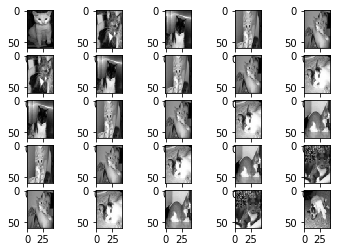

In [10]:
# Визуализация наших данных

fig, axs = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(all_data[i+1*j], plt.gray())

In [11]:
#Перемешиваем наши данные

permut = np.random.permutation(len(all_label))
all_data = all_data[permut]
all_label = all_label[permut]

In [12]:
# Добавляем доп. измерение в виде канала цвета изобрражения (нужно для нейронной сети)

all_data = np.expand_dims(all_data, -1)
all_data.shape

(10028, 59, 41, 1)

In [13]:
# Разбиение наших данных на тестовые и тренировочные наборы данных

x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size = 0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7019, 59, 41, 1), (7019,), (3009, 59, 41, 1), (3009,))

In [20]:
# Построение нашей нейронной сети

i = Input(shape = (x_train[0].shape))                            # Слой ввода данных (какой размерности будем подавать данные в сеть) 
x = BatchNormalization()(i)                                      # Нормализация данных (от 0 до 1)
x = Conv2D(32, (3,3), padding = 'same', activation='relu')(i)    # Слой свертки (32 карты признаков, ядро свертки = 3 на 3 пикселя)
x = Conv2D(32, (3,3), padding = 'same', activation='relu')(x)    # Аналогично
x = Conv2D(32, (3,3), padding = 'same', activation='relu')(x)    # Аналогично
x = MaxPooling2D(2,2)(x)                                         # Слой отбора (из 4 пикселов берем пиксель с наибольшим значением остальные отбрасываем)
x = BatchNormalization()(x)                                      # Нормализация данных (от 0 до 1)
x = Conv2D(64, (3,3), padding = 'same', activation='relu')(x)    # Слой свертки (64 карты признаков, ядро свертки = 3 на 3 пикселя)
x = Conv2D(64, (3,3), padding = 'same', activation='relu')(x)    # Аналогично
x = Conv2D(64, (3,3), padding = 'same', activation='relu')(x)    # Аналогично
x = MaxPooling2D(2,2)(x)                                         # Слой отбора (из 4 пикселов берем пиксель с наибольшим значением остальные отбрасываем)
x = BatchNormalization()(x)                                      # Нормализация данных (от 0 до 1)
x = Conv2D(128, (3,3), padding = 'same', activation='relu')(x)   # Слой свертки (128 карты признаков, ядро свертки = 3 на 3 пикселя)
x = Conv2D(128, (3,3), padding = 'same', activation='relu')(x)   # Слой свертки (128 карты признаков, ядро свертки = 3 на 3 пикселя)
x = Conv2D(128, (3,3), padding = 'same', activation='relu')(x)   # Слой свертки (128 карты признаков, ядро свертки = 3 на 3 пикселя)
x = MaxPooling2D(2,2)(x)                                         # Слой отбора (из 4 пикселов берем пиксель с наибольшим значением остальные отбрасываем)
x = BatchNormalization()(x)                                      # Нормализация данных (от 0 до 1)
x = Flatten()(x)                                                 # Превращаем нашу марицу данных в вектор - данных для дальнейших операций
x = Dense(10, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)                          # Полносвязный слой с 1-им нейроном для бинароного ответа типа '1' или '0' - где 0 - это собака, 1 - кошка

model = Model(i,x)                                               # Сбор модели в единую сеть
model.compile('rmsprop', 'binary_crossentropy', metrics = ['acc']) 

In [21]:
# Архитектура нашей модели

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 59, 41, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 59, 41, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 59, 41, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 59, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 20, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 29, 20, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 20, 64)        1849

In [ ]:
# Обучение модели 

r = model.fit(x_train, y_train, batch_size= 32, epochs = 20, validation_data=(x_test, y_test))

Train on 7019 samples, validate on 3009 samples
Epoch 1/20
2496/7019 [=========>....................] - ETA: 13:48 - loss: 0.7157 - acc: 0.5064